<a href="https://colab.research.google.com/github/jlap96/TrabajoFinalRedes/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CNN - Fahion MNIST**

Clasificación de imágenes.

Importación de librerías y del dataset Fashion-MNIST. Construcción del modelo CNN.

Establecimiento de semillas para reporducibilidad, esto hace que los pesos iniciales, operaciones aleatorias se comporten igual cada vez que se corre el código.



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
np.random.seed(42)
tf.random.set_seed(42)

Cargamos los datos Fashion-MNIST. Esto carga: 60,000 imágenes de entrenamiento, 60,000 etiqueta para entrenamiento. 10,000 imágenes para prueba y 10,000 etiquetas de prueba. Cada imagen contiene tamaño 28x28 en escala de grises.

Mostramos 10 imágenes de ejemplo. Coloca como título la etiqueta del dataset del 0 al 9.



29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) Test: (10000, 28, 28)


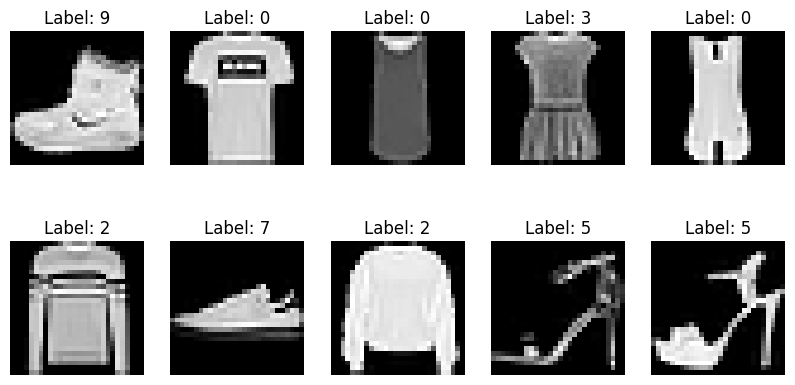

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print('Train:', x_train.shape, 'Test:', x_test.shape)


fig, axes = plt.subplots(2,5, figsize=(10,5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

Normalizamos las imágenes convirtiendo los valores de píxeles de 0-255 a 0-1, esto nos ayudará a que la red entre más rapido y estable.

Redimensionamiento para CNN y ahora damos el formato (batch, height, width, channels)

One-hot-encoding de etiquetas. Convertimos cada etiqueta a un vector.

Imprimimos lo que estuvimos trabajando.

In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


x_train = x_train.reshape(-1, 28,28,1)
x_test = x_test.reshape(-1, 28,28,1)


y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


print('Shapes after preprocess:', x_train.shape, y_train_cat.shape)

Shapes after preprocess: (60000, 28, 28, 1) (60000, 10)


**Baseline**

Definimos el baseline donde comenzamos con la extracción de patrones visuales como bordes, lineas, texturas, aplicamos filtros, kernel y activación ReLu. Reducimos el tamaño para evitar sobreajuste, preparamos los datos para las capas densas con Flatten(). Con Dense(128,relu) aprende combinaciones más abstractas como: forma de zapato, rasgos específicos de cada clase. Con Dense(10, softmax) devolvemos probabilidades para las 10 clases.

Compilamos el modelo con el optimizados adam, con metrica accuracy

In [ ]:
baseline = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])


baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

**Entrenamiento dle baseline**

Comenzamos el entrenamiento del modelo.
Se definen 10 epoca con un lote (batch) de 32 imágenes y reservando el 20% del set de entrenamiento para validación y midiendo el tiempo total para entrenar.

Evaluamos en el set de prueba. Calculando perdida final en test y accuracy final en test.

Registramos los resultados en un DataFrame

In [ ]:
start = time.time()
hist_base = baseline.fit(x_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)
end = time.time()
print('Tiempo (s):', end - start)


loss_b, acc_b = baseline.evaluate(x_test, y_test_cat, verbose=0)
print('Baseline test acc:', acc_b)


df_entry = pd.DataFrame([{
    'model':'baseline',
    'params':'Conv32+Dense128',
    'epochs':10,
    'val_accuracy': hist_base.history['val_accuracy'][-1],
    'test_accuracy': acc_b,
    'time_sec': end - start
}])
print(df_entry)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7999 - loss: 0.5619 - val_accuracy: 0.8865 - val_loss: 0.3196
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8954 - loss: 0.2954 - val_accuracy: 0.8982 - val_loss: 0.2821
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9134 - loss: 0.2415 - val_accuracy: 0.9040 - val_loss: 0.2712
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9278 - loss: 0.2028 - val_accuracy: 0.9065 - val_loss: 0.2681
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9397 - loss: 0.1699 - val_accuracy: 0.9068 - val_loss: 0.2854
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9507 - loss: 0.1414 - val_accuracy: 0.9103 - val_loss: 0.2921
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9589 - loss: 0.1187 - val_accuracy: 0.9104 - val_loss: 0.3170
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9677 - loss: 0.0987 -

Se optimizó el modelo. Sin embargo con estos ajustes no se obtuvo el mejor resultado, por lo que se continuo con otros ajustes.

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.05, height_shift_range=0.05)
datagen.fit(x_train)


model_opt = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.10),


    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.10),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.15),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.30),
    Dense(10, activation='softmax')
])


model_opt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_opt.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,162 (504.54 KB)

 Trainable params: 128,714 (502.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
start = time.time()
hist_opt = model_opt.fit(datagen.flow(x_train, y_train_cat, batch_size=64), epochs=15,
validation_data=(x_test, y_test_cat))
end = time.time()
print('Tiempo (s):', end - start)


loss_o, acc_o = model_opt.evaluate(x_test, y_test_cat, verbose=0)
print('Optimized test acc:', acc_o)

df_entry2 = pd.DataFrame([{
    'model':'optimized',
    'params':'BN+Dropout+Aug',
    'epochs':15,
    'val_accuracy': hist_opt.history['val_accuracy'][-1] if 'val_accuracy' in hist_opt.history else None,
    'test_accuracy': acc_o,
    'time_sec': end - start
}])


# Concatenar y guardar
log = pd.concat([df_entry, df_entry2], ignore_index=True)
log.to_csv('experiments_log.csv', index=False)
print(log)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.7003 - loss: 0.8274 - val_accuracy: 0.8225 - val_loss: 0.4852
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8274 - loss: 0.4642 - val_accuracy: 0.8569 - val_loss: 0.3965
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.8446 - loss: 0.4227 - val_accuracy: 0.8669 - val_loss: 0.3616
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8518 - loss: 0.3955 - val_accuracy: 0.8736 - val_loss: 0.3418
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8590 - loss: 0.3803 - val_accuracy: 0.8689 - val_loss: 0.3554
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8650 - loss: 0.3647 - val_accuracy: 0.8487 - val_loss: 0.4075
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8674 - loss: 0.3539 - val_accuracy: 0.8833 - val_loss: 0.3217
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8699 - loss: 0.3507 - val_accurac

**Modelo optimizado**

S extraen primero patrones como bordes, texturas, etc. Con BatchNorm estabilizamos y aceleramos entrenamiento. MaxPooling reduce la dimensión y Dropout evita sobreajuste pero sin afectar demasiado el aprendizaje.

Después aprende ahora patrones más complejos como curbas, partes de objetos, etc. Continuamos estabilizando y ahora compactamos características.

Ahora capturamos características de alto nivel como forme del objeto completo y aumentamos el Dropout un poco para evitar sobreajuste en la parte más profunda.

En el clasificador final aplanamos la salida convolucional y reducimos la capa densa, ajustamos dropout para regularizar el clasificador y predecimos una de las 10 clases del dataset

In [ ]:
model_opt_v2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.05), # Reducir dropout

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.05), # Reducir dropout

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.10), # Reducir dropout

    Flatten(),
    Dense(128, activation='relu'), # Reducir el tamaño de la capa densa
    Dropout(0.20), # Reducir dropout
    Dense(10, activation='softmax')
])

model_opt_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_opt_v2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

**Entrenamiento del modelo optimizado**

Comenzamos el entrenamiento. Se definen 15 épocas con batch_size de 64y evaluamos el rendimiento en el set de test en cada época.

Medimos el tiempo total de entrenamiento.

Evaluamos el modelo

In [ ]:
start = time.time()
hist_opt_v2 = model_opt_v2.fit(datagen.flow(x_train, y_train_cat, batch_size=64), epochs=15,
validation_data=(x_test, y_test_cat))
end = time.time()
print('Tiempo (s):', end - start)


loss_o_v2, acc_o_v2 = model_opt_v2.evaluate(x_test, y_test_cat, verbose=0)
print('Optimized v2 test acc:', acc_o_v2)


# Añadir al log
df_entry_v2 = pd.DataFrame([{
    'model':'optimized_v2',
    'params':'BN+Dropout(reduced)+Aug',
    'epochs':15,
    'val_accuracy': hist_opt_v2.history['val_accuracy'][-1] if 'val_accuracy' in hist_opt_v2.history else None,
    'test_accuracy': acc_o_v2,
    'time_sec': end - start
}])


# Concatenar y guardar
log = pd.concat([log, df_entry_v2], ignore_index=True)
log.to_csv('experiments_log.csv', index=False)
print(log)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.7178 - loss: 0.7816 - val_accuracy: 0.8401 - val_loss: 0.4447
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8352 - loss: 0.4467 - val_accuracy: 0.8385 - val_loss: 0.4261
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8510 - loss: 0.4013 - val_accuracy: 0.8720 - val_loss: 0.3503
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8606 - loss: 0.3742 - val_accuracy: 0.8665 - val_loss: 0.3743
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8672 - loss: 0.3572 - val_accuracy: 0.8739 - val_loss: 0.3399
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8734 - loss: 0.3422 - val_accuracy: 0.8818 - val_loss: 0.3261
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8754 - loss: 0.3323 - val_accuracy: 0.8526 - val_loss: 0.3815
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8775 - loss: 0.3267 - val_accurac

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


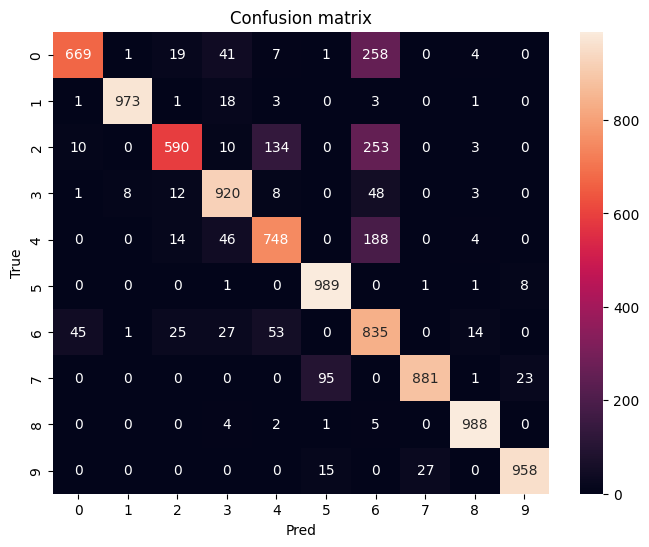

              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1000
           1       0.99      0.97      0.98      1000
           2       0.89      0.59      0.71      1000
           3       0.86      0.92      0.89      1000
           4       0.78      0.75      0.77      1000
           5       0.90      0.99      0.94      1000
           6       0.53      0.83      0.64      1000
           7       0.97      0.88      0.92      1000
           8       0.97      0.99      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.86     10000
   macro avg       0.88      0.86      0.86     10000
weighted avg       0.88      0.86      0.86     10000



In [ ]:
# Predicciones
y_pred = model_opt.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)


# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()


# Reporte clasificación
print(classification_report(y_test, y_pred_classes))